# Paper buying agent and environment
Similar to the Smart House case.


## Representing Agents and Environments
An agent observes the world, and carries out actions in the environment, it also has an internal state that it updates. The environment takes in actions of the agents, updates it internal state and returns the percepts.

In this implementation, the state of the agent and the state of the environment are represented using standard Python variables, which are updated as the state changes. The percepts and the actions are represented as variable-value dictionaries.



In [1]:
import random
import matplotlib.pyplot as plt

### Agent
An agent implements the `go(n)` method, where `n` is an integer. This means that the agent should run for `n` time steps.

The code raises `NotImplementedError()` is a way to specify an abstract method that needs to be overidden in any implemented agent or environment.

In [2]:
class Agent(object):
    def __init__(self,env):
        """set up the agent"""
        self.env=env

    def go(self,n):
        """acts for n time steps"""
        raise NotImplementedError("go")   # abstract method

## Environment
The environment implements a `do(action)` method where *action* is a variable-value dictionary. This returns a percept, which is also a variable-value dictionary. The use of dictionaries allows for structured actions and percepts.

Note that `Environment` is a subclass of `Displayable` so that it can use the display method.

In [ ]:
class Displayable(object):
    """Class that uses 'display'.
    The amount of detail is controlled by max_display_level
    """
    max_display_level = 1   # can be overridden in subclasses

    def display(self,level,*args,**nargs):
        """print the arguments if level is less than or equal to the
        current max_display_level.
        level is an integer.
        the other arguments are whatever arguments print can take.
        """
        if level <= self.max_display_level:
            print(*args, **nargs)  ##if error you are using Python2 not Python3

def visualize(func):
    """A decorator for algorithms that do interactive visualization.
    Ignored here.
    """
    return func

In [6]:
class Environment(Displayable):
    def initial_percepts(self):
        # returns the initial percepts for the agent
        raise NotImplementedError("initial_percepts")   # abstract method

    def do(self,action):
        # does the action in the environment
        # returns the next percept
        raise NotImplementedError("do")   # abstract method

The environment state is given in terms of the *time* and the amount of paper in *stock*. It also remembers the in-stock history and the price history. The percepts are the price and the amount of paper in stock. The action of the agent is the number to buy.

Here we **assume** that the prices are obtained from the *prices* list plus a ran- dom integer in range `[0, max price addon)` plus a linear *”inflation”*. The agent cannot access the price model; it just observes the prices and the amount in stock.

The `pick from dist` method takes in a *item : probability* dictionary, and returns one of the items in proportion to its probability.

In [7]:
class TP_env(Environment):
    prices = [234, 234, 234, 234, 255, 255, 275, 275, 211, 211, 211,
    234, 234, 234, 234, 199, 199, 275, 275, 234, 234, 234, 234, 255,
    255, 260, 260, 265, 265, 265, 265, 270, 270, 255, 255, 260, 260,
    265, 265, 150, 150, 265, 265, 270, 270, 255, 255, 260, 260, 265,
    265, 265, 265, 270, 270, 211, 211, 255, 255, 260, 260, 265, 265,
    260, 265, 270, 270, 205, 255, 255, 260, 260, 265, 265, 265, 265,
    270, 270]
    max_price_addon = 20  # maximum of random value added to get price

    def __init__(self):
        # paper buying agent
        self.time=0
        self.stock=20
        self.stock_history = []  # memory of the stock history
        self.price_history = []  # memory of the price history

    def initial_percepts(self):
        # return initial percepts 
        self.stock_history.append(self.stock)
        price = self.prices[0]+random.randrange(self.max_price_addon)
        self.price_history.append(price)
        return {'price': price,
                'instock': self.stock}

    def do(self, action):
        # does action (buy) and returns percepts (price and instock)
        used = pick_from_dist({6:0.1, 5:0.1, 4:0.2, 3:0.3, 2:0.2, 1:0.1})
        bought = action['buy']
        self.stock = self.stock+bought-used
        self.stock_history.append(self.stock)
        self.time += 1
        price = (self.prices[self.time%len(self.prices)] # repeating pattern
                 +random.randrange(self.max_price_addon) # plus randomness
                 +self.time//2)                          # plus inflation
        self.price_history.append(price)
        return {'price': price,
                'instock': self.stock}

def pick_from_dist(item_prob_dist):
    # returns a value from a distribution. item_prob_dist is an item:probability dictionary, 
    # where the probabilities sum to 1. returns an item chosen in proportion to its probability

    ranreal = random.random()
    for (it,prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError(str(item_prob_dist)+" is not a probability distribution")

### The Agent
The agent does not have access to the price model but can only observe the current price and the amount in stock. It has to decide how much to buy.

The belief state of the agent is an estimate of the average price of the paper, and the total amount of money the agent has spent.

In [8]:
class TP_agent(Agent):
    def __init__(self, env):
        self.env = env
        self.spent = 0
        percepts = env.initial_percepts()
        self.ave = self.last_price = percepts['price']
        self.instock = percepts['instock']
        
    def go(self, n):
        """go for n time steps
        """
        for i in range(n):
            if self.last_price < 0.9*self.ave and self.instock < 60:
                tobuy = 48
            elif self.instock < 12:
                tobuy = 12
            else:
                tobuy = 0
            self.spent += tobuy*self.last_price
            percepts = env.do({'buy': tobuy})
            self.last_price = percepts['price']
            self.ave = self.ave+(self.last_price-self.ave)*0.05
            self.instock = percepts['instock']

Set up an environment and an agent. Run the agent for 100 steps, and determine the average amount spent.

In [10]:
env = TP_env()
ag = TP_agent(env)

ag.go(100)
ag.spent/env.time   ## average spent per time period

824.76

### Plotting
The following plots the price and number in stock history.

In [12]:
class Plot_prices(object):
    """Set up the plot for history of price and number in stock"""
    def __init__(self, ag,env):
        self.ag = ag
        self.env = env
        plt.ion()
        plt.xlabel("Time")
        plt.ylabel("Number in stock Price.")

    def plot_run(self):
        """plot history of price and instock"""
        num = len(env.stock_history)
        plt.plot(range(num),env.stock_history,label="In stock")
        plt.plot(range(num),env.price_history,label="Price")
        plt.legend(loc="upper left")
        plt.draw()

Plot using `plot_run` function.

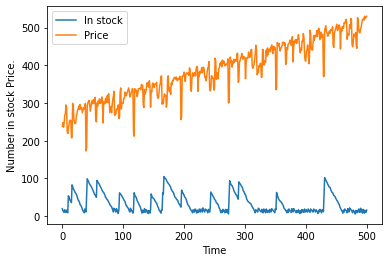

In [14]:
pl = Plot_prices(ag,env)
ag.go(200)
pl.plot_run()